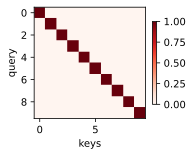

In [53]:
import torch
from d2l import torch as d2l
import torch.nn as nn

attention_weights=torch.eye(10).reshape((1,1,10,10))#torch.eye(n)生成对角线全为1的矩阵
d2l.show_heatmaps(attention_weights,xlabel='keys',ylabel='query')#显示注意力权重

## 平均汇聚

In [54]:
n_train=50
x_train,_=torch.sort(torch.rand(n_train)*5)#0-5之间均匀分布

In [55]:
def f(x):
    return 2*torch.sin(x)+x**0.8
y_train=f(x_train)+torch.normal(0,0.1,(x_train.shape))#加上0.1的噪声
x_test=torch.arange(0,5,0.1)
y_test=f(x_test)
n_test=len(y_test)

In [56]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test,[y_test,y_hat],'x','y',legend=['Truth','Pred'],xlim=[0,5],ylim=[-1,5])
    d2l.plt.plot(x_train,y_train,'o',alpha=0.5)

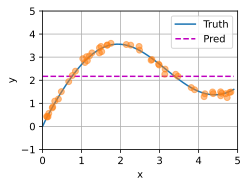

In [57]:
y_hat=torch.repeat_interleave(y_train.mean(),n_test)
plot_kernel_reg(y_hat)

## 非参数（不带参数）高斯核（化简成softmax函数）注意力汇聚

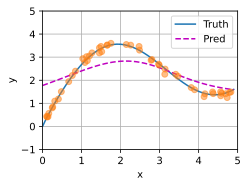

In [58]:
x_repeat=x_test.repeat_interleave(n_train).reshape(-1,n_train)
attention_weight=torch.nn.functional.softmax(-(x_repeat-x_train)**2/2,dim=1)
y_hat=torch.matmul(attention_weight,y_train)
plot_kernel_reg(y_hat)

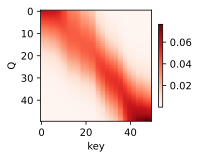

In [59]:
#想办法将attenti_weight变成（1，1，n_test,n_train）的形状
d2l.show_heatmaps(attention_weight.reshape((1,1,n_test,n_train)),xlabel='key',ylabel='Q')

## （高斯核加上参数）带参数的注意力汇聚

In [104]:
#批量矩阵乘法：torch.bmm(),(n,a,b):n：批量，a，b:维度
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.w=nn.Parameter(torch.rand((1,),requires_grad=True))
    def forward(self,query,key,value):
        query=query.repeat_interleave(key.shape[1]).reshape(-1,key.shape[1])
        self.attention_weight=nn.functional.softmax(-((query-key)*self.w)**2/2,dim=1)
        return torch.bmm(self.attention_weight.unsqueeze(1),value.unsqueeze(-1)).reshape(-1)

In [105]:
x_tile=x_train.repeat((n_train,1))
y_tile=y_train.repeat((n_train,1))
key = x_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
value=y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))

epoch:10,loss:0.779490


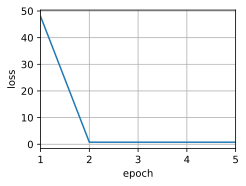

In [112]:
net=NWKernelRegression()
loss=nn.MSELoss(reduction='none')#返回每一个分量的损失，不进行平均或者求和
trainer=torch.optim.SGD(net.parameters(),lr=0.5)
animator=d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])

for epoch in range(10):
    trainer.zero_grad()
    l=loss(net(x_train,key,value),y_train)
    l.sum().backward()
    trainer.step()
    animator.add(epoch+1,float(l.sum()))
    print(f'epoch:{epoch+1},loss:{float(l.sum()):.6f}') 

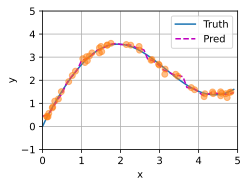

In [113]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

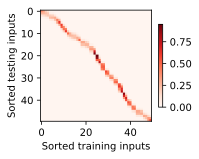

In [114]:
d2l.show_heatmaps(net.attention_weight.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')